# Differential Expression

In [1]:
import os
import sys
import re
from pathlib import Path
from yaml import load
import pickle

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, norm, fisher_exact, mannwhitneyu
from scipy.stats.contingency import margins
from statsmodels.stats.multitest import multipletests

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from larval_gonad.stats import run_chisq
from larval_gonad.plotting import format_pval

In [2]:
sns.set_context('poster')

## Data Loading

In [3]:
# load all of my config settings
config = {}
with open('../config/common.yaml') as fh:
    config.update(load(fh.read()))
    
with open('../config/colors.yaml') as fh:
    config['colors'] = load(fh.read())
    
with open('../science_submission/config.yaml') as fh:
    config.update(load(fh.read()))

In [4]:
# Get list of gene expressed in the experiment
with open('../output/science_submission/background_fbgns.pkl', 'rb') as fh:
    bg = pickle.load(fh)

In [5]:
fbgn2symbol = pd.read_pickle('../output/science_submission/fbgn2symbol.pkl')
fbgn2chrom = pd.read_parquet('../output/x-to-a-wf/fbgn2chrom.parquet')

In [6]:
num_genes = fbgn2chrom.groupby('chrom').size().rename('num_genes')
num_genes.map(lambda x: f'{x:,}').rename('Number of Genes').to_frame()

,Number of Genes
chrom,
chr2L,"3,496"
chr2R,"3,620"
chr3L,"3,456"
chr3R,"4,189"
chr4,111
chrM,38
chrX,"2,669"
chrY,113


In [7]:
# Get mappint of cell_id to short cluster name, remove unknown clusters
clusters = (
    pd.read_parquet('../output/scrnaseq-wf/clusters.parquet')
    .assign(cluster = lambda df: pd.Categorical(df.cluster.map(config['short_cluster_annot']), ordered=True, categories=config['short_cluster_order']))
    .dropna()
)

In [8]:
autosomes = ['chr2L', 'chr2R', 'chr3L', 'chr3R']

## Germline DEG

### Genes up regulated in Gonia (vs Cytes) are enriched from the X and 4th

p-value x: 0.0061, p-value 4: 0.0005


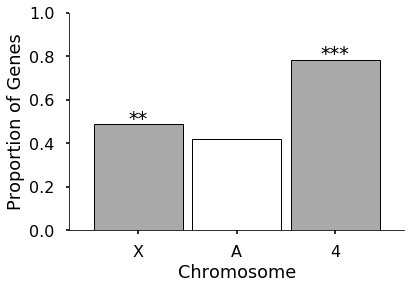

In [9]:
df = (
    pd.read_csv('../output/scrnaseq-wf/germcell_deg/gonia_vs_cytes.tsv', sep='\t', index_col=0)
    .rename_axis('FBgn')
    .join(fbgn2chrom)
    .assign(biased = lambda df: (df.p_val_adj <= 0.01) & (df.avg_logFC > 0))
    .loc[:, ['chrom', 'biased']]
    .replace({
        'chrX': 'X',
        'chr2L': 'A',
        'chr2R': 'A',
        'chr3L': 'A',
        'chr3R': 'A',
        'chr4': '4',
    })
)

ct = df.groupby('chrom').biased.value_counts().unstack().loc[['X', 'A', '4']].T

_, pvalx = fisher_exact(ct[['X', 'A']], alternative='two-sided')
_, pval4 = fisher_exact(ct[['4', 'A']], alternative='two-sided')
print(f'p-value x: {pvalx:0.4f}, p-value 4: {pval4:0.4f}')

dat = df.groupby('chrom').biased.mean()[['X', 'A', '4']]
ax = dat.plot(kind='bar', width=.9, color=['darkgray', 'w', 'darkgray'], edgecolor='k', lw=1)
format_pval(ax, 0, dat['X'], pvalx)
format_pval(ax, 2, dat['4'], pval4)
ax.set(ylim=(0, 1), ylabel='Proportion of Genes', xlabel='Chromosome')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
sns.despine(ax=ax);

### Genes up downregulated in E1° (vs SP) are depleted from the X and 4th

p-value x: 0.0401, p-value 4: 0.0008


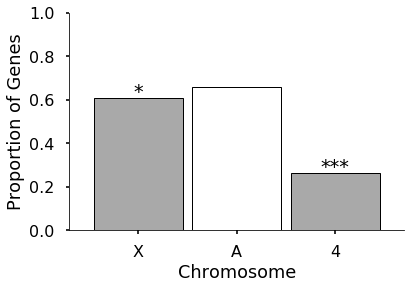

In [10]:
df = (
    pd.read_csv('../output/scrnaseq-wf/germcell_deg/gonia_vs_early.tsv', sep='\t', index_col=0)
    .rename_axis('FBgn')
    .join(fbgn2chrom)
    .assign(biased = lambda df: (df.p_val_adj <= 0.01) & (df.avg_logFC < 0))
    .loc[:, ['chrom', 'biased']]
    .replace({
        'chrX': 'X',
        'chr2L': 'A',
        'chr2R': 'A',
        'chr3L': 'A',
        'chr3R': 'A',
        'chr4': '4',
    })
)

ct = df.groupby('chrom').biased.value_counts().unstack().loc[['X', 'A', '4']].T

_, pvalx = fisher_exact(ct[['X', 'A']], alternative='two-sided')
_, pval4 = fisher_exact(ct[['4', 'A']], alternative='two-sided')
print(f'p-value x: {pvalx:0.4f}, p-value 4: {pval4:0.4f}')

dat = df.groupby('chrom').biased.mean()[['X', 'A', '4']]
ax = dat.plot(kind='bar', width=.9, color=['darkgray', 'w', 'darkgray'], edgecolor='k', lw=1)
format_pval(ax, 0, dat['X'], pvalx)
format_pval(ax, 2, dat['4'], pval4)
    
ax.set(ylim=(0, 1), ylabel='Proportion of Genes', xlabel='Chromosome')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
sns.despine(ax=ax);

### Genes up downregulated in M1° (vs E1°) are depleted from the X and abscent from the 4th

chrom,X,A,4
biased,,,
False,114.0,763.0,8.0
True,10.0,388.0,0.0


p-value x: 0.0000, p-value 4: 0.0576


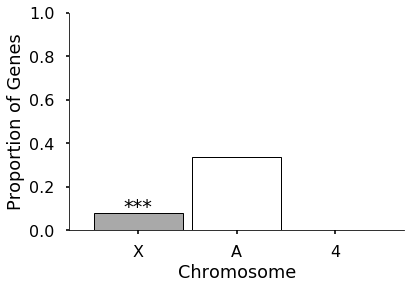

In [11]:
df = (
    pd.read_csv('../output/scrnaseq-wf/germcell_deg/early_vs_mid.tsv', sep='\t', index_col=0)
    .rename_axis('FBgn')
    .join(fbgn2chrom)
    .assign(biased = lambda df: (df.p_val_adj <= 0.01) & (df.avg_logFC < 0))
    .loc[:, ['chrom', 'biased']]
    .replace({
        'chrX': 'X',
        'chr2L': 'A',
        'chr2R': 'A',
        'chr3L': 'A',
        'chr3R': 'A',
        'chr4': '4',
    })
)

ct = df.groupby('chrom').biased.value_counts().unstack().loc[['X', 'A', '4']].T.fillna(0)
display(ct)

_, pvalx = fisher_exact(ct[['X', 'A']], alternative='two-sided')
_, pval4 = fisher_exact(ct[['4', 'A']], alternative='two-sided')
print(f'p-value x: {pvalx:0.4f}, p-value 4: {pval4:0.4f}')

dat = df.groupby('chrom').biased.mean()[['X', 'A', '4']]
ax = dat.plot(kind='bar', width=.9, color=['darkgray', 'w', 'darkgray'], edgecolor='k', lw=1)
format_pval(ax, 0, dat['X'], pvalx)
format_pval(ax, 2, dat['4'], pval4)
ax.set(ylim=(0, 1), ylabel='Proportion of Genes', xlabel='Chromosome')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
sns.despine(ax=ax);

### Genes up downregulated in L1° (vs M1°) are depleted from X and 4th, but gene counts are very low.

chrom,X,A,4
biased,,,
False,18.0,63.0,1.0
True,1.0,21.0,0.0


p-value x: 0.0674, p-value 4: 1.0000


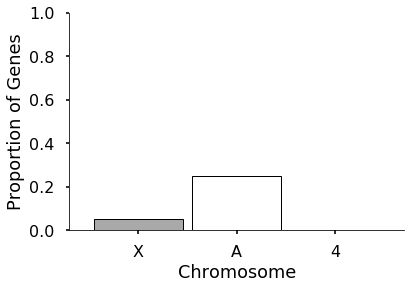

In [12]:
df = (
    pd.read_csv('../output/scrnaseq-wf/germcell_deg/mid_vs_late.tsv', sep='\t', index_col=0)
    .rename_axis('FBgn')
    .join(fbgn2chrom)
    .assign(biased = lambda df: (df.p_val_adj <= 0.01) & (df.avg_logFC < 0))
    .loc[:, ['chrom', 'biased']]
    .replace({
        'chrX': 'X',
        'chr2L': 'A',
        'chr2R': 'A',
        'chr3L': 'A',
        'chr3R': 'A',
        'chr4': '4',
    })
)

ct = df.groupby('chrom').biased.value_counts().unstack().loc[['X', 'A', '4']].T.fillna(0)
display(ct)

_, pvalx = fisher_exact(ct[['X', 'A']], alternative='two-sided')
_, pval4 = fisher_exact(ct[['4', 'A']], alternative='two-sided')
print(f'p-value x: {pvalx:0.4f}, p-value 4: {pval4:0.4f}')

dat = df.groupby('chrom').biased.mean()[['X', 'A', '4']]
ax = dat.plot(kind='bar', width=.9, color=['darkgray', 'w', 'darkgray'], edgecolor='k', lw=1)
format_pval(ax, 0, dat['X'], pvalx)
format_pval(ax, 2, dat['4'], pval4)
ax.set(ylim=(0, 1), ylabel='Proportion of Genes', xlabel='Chromosome')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
sns.despine(ax=ax);

## Demasculinization of the X chromosome

### Bulk RNA-Seq shows demasculinization of the X and the 4th.

In [37]:
bulk_sig = (
    pd.read_csv('../output/bulk-rnaseq-wf/deseq2_results_tcp_vs_ocp.tsv', sep='\t', index_col=0)
    .dropna()
    .assign(testis_bias = lambda df: (df.log2FoldChange >= 1) & (df.padj <= 0.01))
    .assign(ovary_bias = lambda df: (df.log2FoldChange <= -1) & (df.padj <= 0.01))
    .join(fbgn2chrom, how='outer')
    .fillna({
        'testis_bias': False,
        'ovary_bias': False,
    })
    .replace({
        'chrX': 'X',
        'chr2L': '2L',
        'chr2R': '2R',
        'chr3L': '3L',
        'chr3R': '3R',
        'chr4': '4',
    })
)

bulk_sig.loc[bulk_sig.testis_bias, 'bias'] = 'testis'
bulk_sig.loc[bulk_sig.ovary_bias, 'bias'] = 'ovary'
bulk_sig.bias = bulk_sig.bias.fillna('None')

MALE_BIAS = bulk_sig[bulk_sig.testis_bias].index

𝛘^2: 230.1680, p-value: 0.0000, df: 10


chrom                            X         2L         2R         3L  \
bias   type                                                           
ovary  observed           613.0000   429.0000   535.0000   433.0000   
       adj std residual    13.1164    -4.5171     0.1673    -4.0072   
       flag_sig             1.0000     1.0000     0.0000     1.0000   
None   observed          1425.0000  1941.0000  2086.0000  1970.0000   
       adj std residual    -3.1961    -0.9273     1.9160     1.0386   
       flag_sig             1.0000     0.0000     0.0000     0.0000   
testis observed           631.0000  1126.0000   999.0000  1053.0000   
       adj std residual    -6.7326     4.5339    -2.2233     1.9889   
       flag_sig             1.0000     1.0000     0.0000     0.0000   

chrom                           3R        4  
bias   type                                  
ovary  observed           538.0000  29.0000  
       adj std residual    -3.8727   3.4138  
       flag_sig             1.0000   1.0000  
None   observed          2373.0000  66.0000  
       adj std residual     0.6452   0.6908  
       flag_sig             0.0000   0.0000  
testis observed          1278.0000  16.0000  
       adj std residual     2.3138  -3.4155  
       flag_sig             1.0000   1.0000

p-value x: 0.0000, p-value 4: 0.0026


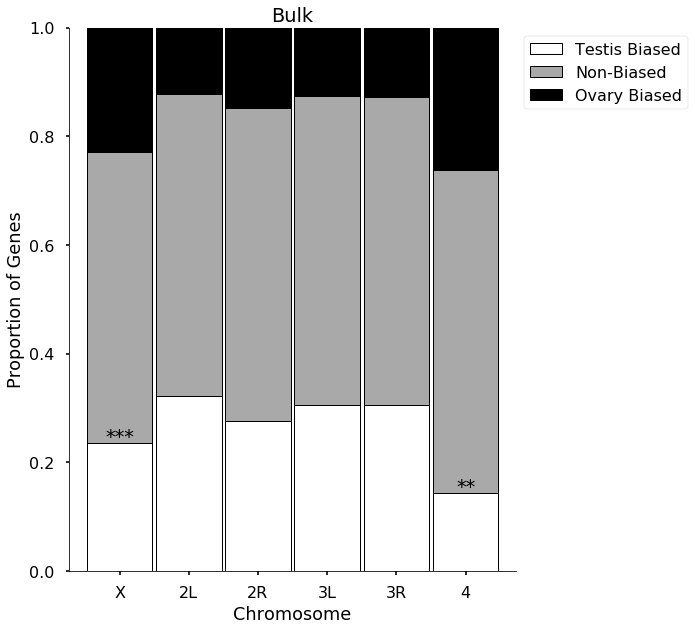

In [38]:
title = 'Bulk'
ct = bulk_sig.groupby('chrom').bias.value_counts().unstack().loc[['X', '2L', '2R', '3L', '3R', '4']].T
res = run_chisq(ct)
display(res.reindex(['ovary', 'None', 'testis'], level=0).loc[(slice(None), ['observed', 'adj std residual', 'flag_sig']), :])

pvalx = res.loc[('testis', 'fdr q-value'), 'X']
pval4 = res.loc[('testis', 'fdr q-value'), '4']
print(f'p-value x: {pvalx:0.4f}, p-value 4: {pval4:0.4f}')

dat = ct.div(ct.sum()).T[['testis', 'None', 'ovary']]
ax = dat.plot(kind='bar', stacked=True, width=.95, color=['w', 'darkgray', 'k'], edgecolor='k', lw=1, figsize=(8, 10))
ax.set(ylim=(0, 1), ylabel='Proportion of Genes', xlabel='Chromosome', title=title)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
sns.despine(ax=ax)
format_pval(ax, 0, dat.loc['X', 'testis'], pvalx)
format_pval(ax, 5, dat.loc['4', 'testis'], pval4)
plt.legend(['Testis Biased', 'Non-Biased', 'Ovary Biased'], loc='upper left', bbox_to_anchor=(1, 1));

In [39]:
dat

bias,testis,None,ovary
chrom,,,
X,0.236418,0.533908,0.229674
2L,0.322082,0.555206,0.122712
2R,0.275967,0.576243,0.147790
3L,0.304688,0.570023,0.125289
3R,0.305085,0.566484,0.128432
4,0.144144,0.594595,0.261261


### SP testis-biased genes do not show evidence of X or 4th demasculinization.

𝛘^2: 51.0429, p-value: 0.0000, df: 10


chrom                            X         2L         2R         3L  \
bias   type                                                           
ovary  observed           114.0000    91.0000   133.0000    76.0000   
       adj std residual     4.1864    -1.5331     2.6743    -3.0758   
       flag_sig             1.0000     0.0000     0.0000     1.0000   
None   observed          2523.0000  3382.0000  3464.0000  3347.0000   
       adj std residual    -4.9126     1.8530    -1.8113     2.2068   
       flag_sig             1.0000     0.0000     0.0000     0.0000   
testis observed            32.0000    23.0000    23.0000    33.0000   
       adj std residual     2.5274    -1.0414    -1.2355     1.1556   
       flag_sig             0.0000     0.0000     0.0000     0.0000   

chrom                           3R         4  
bias   type                                   
ovary  observed           106.0000    6.0000  
       adj std residual    -2.0367    1.4915  
       flag_sig             0.0000    0.0000  
None   observed          4057.0000  102.0000  
       adj std residual     2.5063   -2.3842  
       flag_sig             0.0000    0.0000  
testis observed            26.0000    3.0000  
       adj std residual    -1.4795    2.2623  
       flag_sig             0.0000    0.0000

p-value x: 0.0518, p-value 4: 0.0695


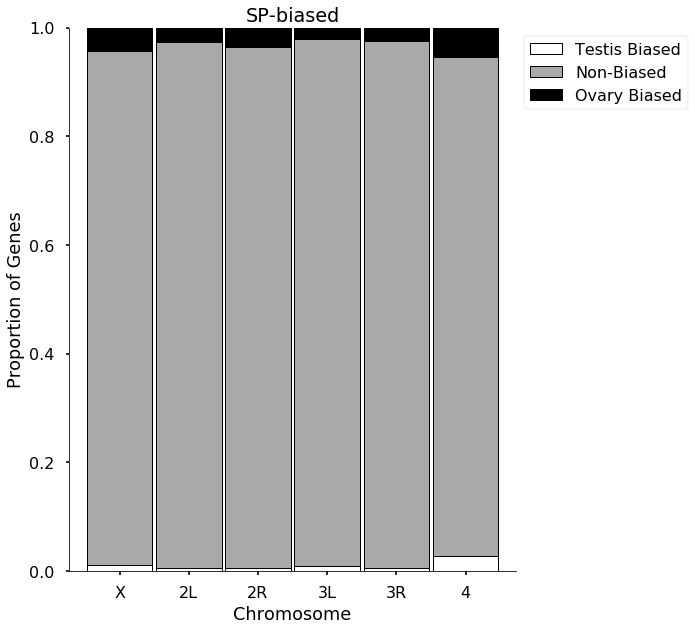

In [15]:
title = 'SP-biased'
BIASED = (
    pd.read_csv('../output/scrnaseq-wf/germcell_deg/gonia_vs_cytes.tsv', sep='\t', index_col=0)
    .query('p_val_adj <= 0.01 & avg_logFC > 0')
    .index.tolist()
)

_bulk_sig = bulk_sig.copy()
_bulk_sig.loc[~_bulk_sig.index.isin(BIASED), 'bias'] = 'None'
ct = _bulk_sig.groupby('chrom').bias.value_counts().unstack().loc[['X', '2L', '2R', '3L', '3R', '4']].T.fillna(0)

res = run_chisq(ct)
display(res.reindex(['ovary', 'None', 'testis'], level=0).loc[(slice(None), ['observed', 'adj std residual', 'flag_sig']), :])

pvalx = res.loc[('testis', 'fdr q-value'), 'X']
pval4 = res.loc[('testis', 'fdr q-value'), '4']
print(f'p-value x: {pvalx:0.4f}, p-value 4: {pval4:0.4f}')

dat = ct.div(ct.sum()).T[['testis', 'None', 'ovary']]
ax = dat.plot(kind='bar', stacked=True, width=.95, color=['w', 'darkgray', 'k'], edgecolor='k', lw=1, figsize=(8, 10))
ax.set(ylim=(0, 1), ylabel='Proportion of Genes', xlabel='Chromosome', title=title)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
sns.despine(ax=ax)
format_pval(ax, 0, dat.loc['X', 'testis'], pvalx)
format_pval(ax, 5, dat.loc['4', 'testis'], pval4)
plt.legend(['Testis Biased', 'Non-Biased', 'Ovary Biased'], loc='upper left', bbox_to_anchor=(1, 1));

### Cyte testis-biased genes show evidence of X demasculinization and tend to have 4th demasculinization

𝛘^2: 50.7068, p-value: 0.0000, df: 10


chrom                            X         2L         2R         3L  \
bias   type                                                           
ovary  observed             0.0000     0.0000     1.0000     2.0000   
       adj std residual    -1.0379    -1.2223    -0.2404     0.8396   
       flag_sig             0.0000     0.0000     0.0000     0.0000   
None   observed          2437.0000  3076.0000  3241.0000  3088.0000   
       adj std residual     3.3199    -3.2472     0.0819    -0.3024   
       flag_sig             1.0000     1.0000     0.0000     0.0000   
testis observed           232.0000   420.0000   378.0000   366.0000   
       adj std residual    -3.2620     3.3257    -0.0675     0.2521   
       flag_sig             1.0000     1.0000     0.0000     0.0000   

chrom                           3R         4  
bias   type                                   
ovary  observed             2.0000    1.0000  
       adj std residual     0.5431    4.9537  
       flag_sig             0.0000    1.0000  
None   observed          3750.0000  106.0000  
       adj std residual     0.0653    2.0688  
       flag_sig             0.0000    0.0000  
testis observed           437.0000    4.0000  
       adj std residual    -0.0982   -2.3710  
       flag_sig             0.0000    0.0000

p-value x: 0.0074, p-value 4: 0.0720


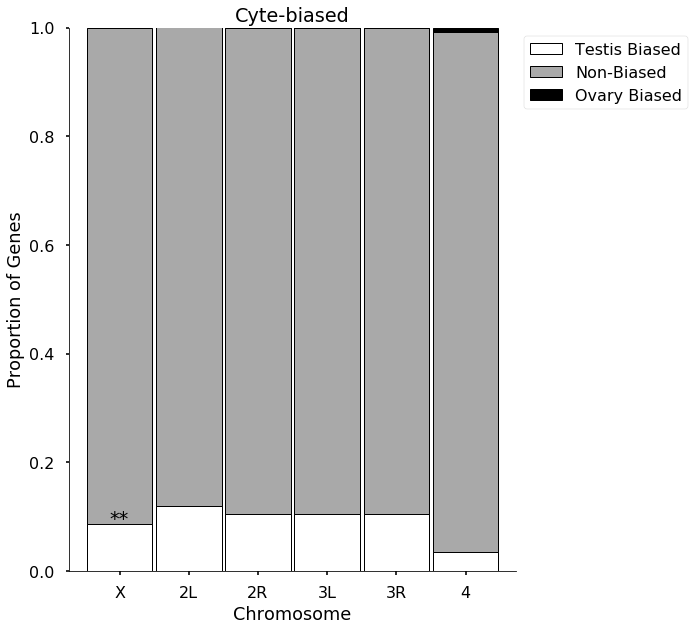

In [16]:
title = 'Cyte-biased'
BIASED = (
    pd.read_csv('../output/scrnaseq-wf/germcell_deg/gonia_vs_cytes.tsv', sep='\t', index_col=0)
    .query('p_val_adj <= 0.01 & avg_logFC < 0')
    .index.tolist()
)

_bulk_sig = bulk_sig.copy()
_bulk_sig.loc[~_bulk_sig.index.isin(BIASED), 'bias'] = 'None'
ct = _bulk_sig.groupby('chrom').bias.value_counts().unstack().loc[['X', '2L', '2R', '3L', '3R', '4']].T.fillna(0)

res = run_chisq(ct)
display(res.reindex(['ovary', 'None', 'testis'], level=0).loc[(slice(None), ['observed', 'adj std residual', 'flag_sig']), :])

pvalx = res.loc[('testis', 'fdr q-value'), 'X']
pval4 = res.loc[('testis', 'fdr q-value'), '4']
print(f'p-value x: {pvalx:0.4f}, p-value 4: {pval4:0.4f}')

dat = ct.div(ct.sum()).T[['testis', 'None', 'ovary']]
ax = dat.plot(kind='bar', stacked=True, width=.95, color=['w', 'darkgray', 'k'], edgecolor='k', lw=1, figsize=(8, 10))
ax.set(ylim=(0, 1), ylabel='Proportion of Genes', xlabel='Chromosome', title=title)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
sns.despine(ax=ax)
format_pval(ax, 0, dat.loc['X', 'testis'], pvalx)
format_pval(ax, 5, dat.loc['4', 'testis'], pval4)
plt.legend(['Testis Biased', 'Non-Biased', 'Ovary Biased'], loc='upper left', bbox_to_anchor=(1, 1));

## Gene Movement

https://genome.cshlp.org/content/19/5/897.long

For DNA-based relocated copies, we observed a higher male-biased expression for X→A movement in comparison to A→ (Table 4), although not significant due to small sample size. However, we found the statistically significant opposite pattern for DNA-based parental copies. X→A parental copies have significant lower male-biased expression compared with A→ cases (Fisher's exact test, P = 0.03; Table 4). The same trend is observed for our RNA-based relocations (Fisher's exact test, P ≤ 0.001; Table 5).

https://genome.cshlp.org/content/19/5/897/T4.expansion.html

https://genome.cshlp.org/content/19/5/897/T5.expansion.html

Note, that it is only significant the parental for both

In [75]:
assembly = config['assembly']
tag = config['tag']
pth = Path(os.environ['REFERENCES_DIR'], f'{assembly}/{tag}/fb_annotation/{assembly}_{tag}.fb_annotation')

# Create a FBgn sanitizer using secondary IDs
mapper = {}
for record in pd.read_csv(pth, sep='\t').to_records():
    mapper[record.primary_FBgn] = record.primary_FBgn
    
    try:
        for g in record.secondary_FBgn.split(','):
            mapper[g] = record.primary_FBgn
    except AttributeError:
        pass

In [85]:
movement = (
    pd.read_excel('../data/external/maria/dm6_ver78_genetype.new.xlsx')
    .query('gene_type == ["D", "R", "Dl", "Rl"] and m_type == "M"')
    .assign(child_chrom = lambda df: df.note.str.extract('(chr.*?)-'))
    .assign(parent_chrom = lambda df: df.note.str.extract('-(chr.*?)[:;]'))
    .assign(child_FBgn = lambda df: df.child_id.map(mapper))
    .assign(parent_FBgn = lambda df: df.parent_id.map(mapper))
    .drop(['child_id', 'parent_id', 'note', 'm_type'], axis=1)
) 

movement.loc[(movement.parent_chrom == "chrX") & movement.child_chrom.isin(autosomes), 'movement'] = 'X -> A'
movement.loc[movement.parent_chrom.isin(autosomes) & (movement.child_chrom == "chrX"), 'movement'] = 'A -> X'
movement.loc[movement.parent_chrom.isin(autosomes) & movement.child_chrom.isin(autosomes), 'movement'] = 'A -> A'

movement = movement.query('movement != "A -> X"').dropna().copy()

In [87]:
movement.groupby(['gene_type', 'movement']).size().unstack()

movement,A -> A,X -> A
gene_type,,
D,16,11
Dl,66,30
R,13,12
Rl,28,15


### Gene Movement and Testis-biased Expression

#### Parent gene location is not associated with testis biased expression

In [88]:
ct = movement.join(bulk_sig.bias.replace({'ovary': 'Not Biased', 'None': 'Not Biased'}), on='parent_FBgn').groupby('movement').bias.value_counts().unstack().fillna(0)
display(ct)
fisher_exact(ct)[1]

bias,Not Biased,testis
movement,,
A -> A,88,35
X -> A,51,17


0.7344821639702598

#### Child genes that moved from the X are enriched with testis biased expression

In [89]:
ct = movement.join(bulk_sig.bias.replace({'ovary': 'Not Biased', 'None': 'Not Biased'}), on='child_FBgn').groupby('movement').bias.value_counts().unstack().fillna(0)
display(ct)
fisher_exact(ct)[1]

bias,Not Biased,testis
movement,,
A -> A,62,61
X -> A,23,45


0.03334204758345051

##### DNA based movements show no association

In [90]:
ct = movement.join(bulk_sig.bias.replace({'ovary': 'Not Biased', 'None': 'Not Biased'}), on='child_FBgn').query('gene_type == ["D", "Dl"]').groupby('movement').bias.value_counts().unstack().fillna(0)
display(ct)
fisher_exact(ct)[1]

bias,Not Biased,testis
movement,,
A -> A,44,38
X -> A,17,24


0.2519495829844909

##### RNA based movements tend show testis biased enrichment

In [91]:
ct = movement.join(bulk_sig.bias.replace({'ovary': 'Not Biased', 'None': 'Not Biased'}), on='child_FBgn').query('gene_type == ["R", "Rl"]').groupby('movement').bias.value_counts().unstack().fillna(0)
display(ct)
fisher_exact(ct)[1]

bias,Not Biased,testis
movement,,
A -> A,18,23
X -> A,6,21


0.07662366163711533

### Gene Movement and Gonia Biased Expression

#### There is no association of the parent gene and Gonia biased expression

In [92]:
BIASED = (
    pd.read_csv('../output/scrnaseq-wf/germcell_deg/gonia_vs_cytes.tsv', sep='\t', index_col=0)
    .query('p_val_adj <= 0.01 & avg_logFC > 0')
    .index.tolist()
)

_movement = movement[['parent_FBgn', 'child_FBgn', 'movement']].copy()
_movement['bias'] = False
_movement.loc[_movement.parent_FBgn.isin(BIASED), 'bias'] = True

ct = _movement.groupby('movement').bias.value_counts().unstack().fillna(0)
display(ct)
fisher_exact(ct)[1]

bias,False,True
movement,,
A -> A,108,15
X -> A,55,13


0.20620664603288402

#### Child genes that moved from the X show an enrichment of gonia biased expression

In [93]:
BIASED = (
    pd.read_csv('../output/scrnaseq-wf/germcell_deg/gonia_vs_cytes.tsv', sep='\t', index_col=0)
    .query('p_val_adj <= 0.01 & avg_logFC > 0')
    .index.tolist()
)

_movement = movement[['parent_FBgn', 'child_FBgn', 'movement']].copy()
_movement['bias'] = False
_movement.loc[_movement.child_FBgn.isin(BIASED), 'bias'] = True

ct = _movement.groupby('movement').bias.value_counts().unstack().fillna(0)
display(ct)
fisher_exact(ct)[1]

bias,False,True
movement,,
A -> A,121,2
X -> A,57,11


0.000261011646157819

### Gene Movement and Cyte Biased Expression

#### There is no association of the parent gene and Cyte biased expression

In [94]:
BIASED = (
    pd.read_csv('../output/scrnaseq-wf/germcell_deg/gonia_vs_cytes.tsv', sep='\t', index_col=0)
    .query('p_val_adj <= 0.01 & avg_logFC < 0')
    .index.tolist()
)

_movement = movement[['parent_FBgn', 'child_FBgn', 'movement']].copy()
_movement['bias'] = False
_movement.loc[_movement.parent_FBgn.isin(BIASED), 'bias'] = True

ct = _movement.groupby('movement').bias.value_counts().unstack().fillna(0)
display(ct)
fisher_exact(ct)[1]

bias,False,True
movement,,
A -> A,108,15
X -> A,62,6


0.6303398305971033

#### There is no association of the child gene and Cyte biased expression

In [95]:
BIASED = (
    pd.read_csv('../output/scrnaseq-wf/germcell_deg/gonia_vs_cytes.tsv', sep='\t', index_col=0)
    .query('p_val_adj <= 0.01 & avg_logFC < 0')
    .index.tolist()
)

_movement = movement[['parent_FBgn', 'child_FBgn', 'movement']].copy()
_movement['bias'] = False
_movement.loc[_movement.child_FBgn.isin(BIASED), 'bias'] = True

ct = _movement.groupby('movement').bias.value_counts().unstack().fillna(0)
display(ct)
fisher_exact(ct)[1]

bias,False,True
movement,,
A -> A,81,42
X -> A,38,30


0.2124038982824139

In [96]:
BIASED = (
    pd.read_csv('../output/scrnaseq-wf/germcell_deg/gonia_vs_cytes.tsv', sep='\t', index_col=0)
    .query('p_val_adj <= 0.01 & avg_logFC < 0')
    .index.tolist()
)

_movement = movement[['parent_FBgn', 'child_FBgn', 'movement']].copy()
_movement['bias'] = False
_movement.loc[_movement.child_FBgn.isin(BIASED), 'bias'] = True

ct = _movement.groupby('movement').bias.value_counts().unstack().fillna(0)
display(ct)
fisher_exact(ct)[1]

bias,False,True
movement,,
A -> A,81,42
X -> A,38,30


0.2124038982824139

In [109]:
df = pd.pivot_table(
    (
        pd.read_parquet('../output/scrnaseq-wf/raw_by_cluster.parquet')
        .assign(cluster=lambda df: df.cluster.map(config['short_cluster_annot']))
        .query('cluster == ["SP", "M1º"]')
        .assign(flag_expressed=lambda df: df.UMI > 10)
    ),
    index='FBgn',
    columns='cluster',
    values='flag_expressed'
)

In [110]:
ct = movement.join(df, on='child_FBgn').loc[:, ['movement', 'SP', 'M1º']].dropna().groupby('movement').sum()
display(ct)
run_chisq(ct)

,SP,M1º
movement,,
A -> A,69,75
X -> A,50,55


𝛘^2: 0.0067, p-value: 0.9346, df: 1


SP      M1º
movement type                              
A -> A   observed          69.0000  75.0000
         expected          68.8193  75.1807
         residual           0.1807  -0.1807
         adj std residual   0.0464  -0.0464
         X^2                0.0005   0.0004
         fdr q-value        0.3985   0.3985
         flag_sig           0.0000   0.0000
X -> A   observed          50.0000  55.0000
         expected          50.1807  54.8193
         residual          -0.1807   0.1807
         adj std residual  -0.0464   0.0464
         X^2                0.0007   0.0006
         fdr q-value        0.3985   0.3985
         flag_sig           0.0000   0.0000

### Gene movement and missingness

In [28]:
tpm = (
    pd.read_parquet('../output/scrnaseq-wf/tpm.parquet')
    .assign(cluster=lambda df: df.cluster.map(config['short_cluster_annot']))
    .query('cluster == "M1º"')
    .TPM
    .rename('M1')
)

In [29]:
BIASED = (
    pd.read_csv('../output/scrnaseq-wf/germcell_deg/gonia_vs_cytes.tsv', sep='\t', index_col=0)
    .assign(gonia_biased=lambda df: (df.p_val_adj <= 0.01) & (df.avg_logFC > 0))
    .assign(cyte_biased=lambda df: (df.p_val_adj <= 0.01) & (df.avg_logFC < 0))
    .assign(gonia_cyte_bias=lambda df: df[['gonia_biased', 'cyte_biased']].idxmax(axis=1))
    .gonia_cyte_bias
)

In [30]:
df = movement.join(tpm, on='child_FBgn').join(BIASED, on='child_FBgn')

In [31]:
df.loc[(df.M1 == 0), 'gonia_cyte_bias'] = 'Not Expressed'
df.loc[(df.M1.isnull()), 'gonia_cyte_bias'] = 'Missing'
df.fillna({'gonia_cyte_bias': 'Not Biased'}, inplace=True)

In [32]:
ct = df.groupby('movement').gonia_cyte_bias.value_counts().unstack()

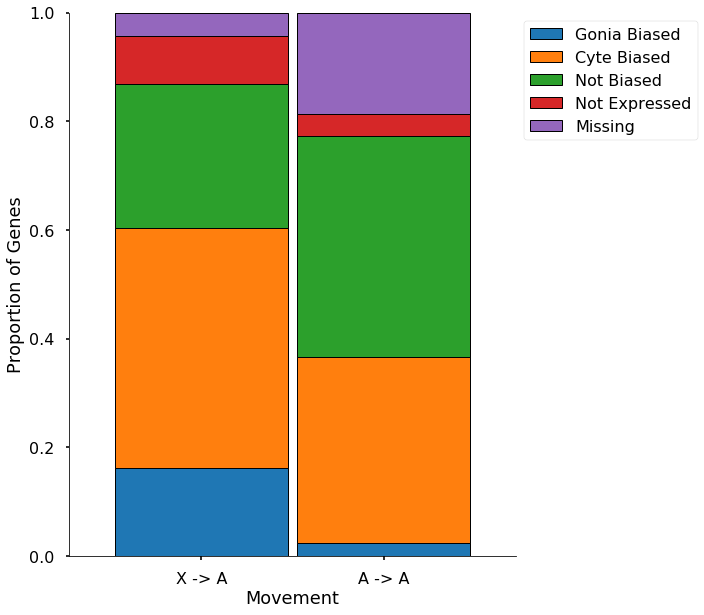

In [33]:
ax = ct.div(ct.sum(axis=1), axis='rows').loc[['X -> A', 'A -> A'], ['gonia_biased', 'cyte_biased', 'Not Biased', 'Not Expressed', 'Missing']].plot(kind='bar', stacked=True, width=.95, figsize=(8, 10), edgecolor='k', lw=1)
plt.legend(['Gonia Biased', 'Cyte Biased', 'Not Biased', 'Not Expressed', 'Missing'], loc='upper left', bbox_to_anchor=[1, 1])
ax.set(ylim=(0, 1), ylabel='Proportion of Genes', xlabel='Movement')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
sns.despine(ax=ax)

In [34]:
res = run_chisq(ct)
res.loc[(slice(None), ['observed', 'adj std residual', 'flag_sig']), :]

𝛘^2: 23.1911, p-value: 0.0001, df: 4


gonia_cyte_bias            Missing  Not Biased  Not Expressed  cyte_biased  \
movement type                                                                
A -> A   observed          23.0000     50.0000         5.0000      42.0000   
         adj std residual   2.7571      1.9597        -1.3516      -1.3616   
         flag_sig           1.0000      0.0000         0.0000       0.0000   
X -> A   observed           3.0000     18.0000         6.0000      30.0000   
         adj std residual  -2.7571     -1.9597         1.3516       1.3616   
         flag_sig           1.0000      0.0000         0.0000       0.0000   

gonia_cyte_bias            gonia_biased  
movement type                            
A -> A   observed                 3.000  
         adj std residual        -3.488  
         flag_sig                 1.000  
X -> A   observed                11.000  
         adj std residual         3.488  
         flag_sig                 1.000

In [35]:
ct2 = pd.concat([ct[['Not Expressed', 'Missing']].sum(axis=1), ct[['Not Biased', 'cyte_biased', 'gonia_biased']].sum(axis=1)], axis=1).rename({0: 'Off', 1: 'On'}, axis=1)

display(ct2)
pval = fisher_exact(ct2, alternative='two-sided')[1]
print(f"fisher's pval: {pval:0.4f}")

,Off,On
movement,,
A -> A,28,95
X -> A,9,59


fisher's pval: 0.1285


In [36]:
ct2 = pd.concat([ct['Missing'], ct[['Not Expressed', 'Not Biased', 'cyte_biased', 'gonia_biased']].sum(axis=1)], axis=1).rename({0: 'Not Missing'}, axis=1)

display(ct2)
pval = fisher_exact(ct2, alternative='two-sided')[1]
print(f"fisher's pval: {pval:0.4f}")

,Missing,Not Missing
movement,,
A -> A,23,100
X -> A,3,65


fisher's pval: 0.0071


## Repeat what Maria did.

In [327]:
maria = (
    pd.read_csv('../output/notebook/2019-04-16_movement_data.csv', index_col=0)
    .assign(movement=lambda df: pd.Categorical(
        df[['moved_x_to_a', 'moved_a_to_x', 'moved_a_to_a']].idxmax(axis=1), 
        ordered=True,
        categories=['moved_x_to_a', 'moved_a_to_a', 'moved_a_to_x']
    ))
    .fillna({
        'biomarker_cluster': "None",
        'bias_gonia_vs_mid_child': "None",
        'bias_gonia_vs_mid_parent': "None",
        'SP_child': 0,
        'M1_child': 0,
        'SP_parent': 0,
        'M1_parent': 0
    })
    .assign(log_M1_child=lambda df: np.log(df.M1_child + 1))
)

In [328]:
maria.groupby('movement').M1_child.size()

movement
moved_x_to_a     68
moved_a_to_a    123
moved_a_to_x     54
Name: M1_child, dtype: int64

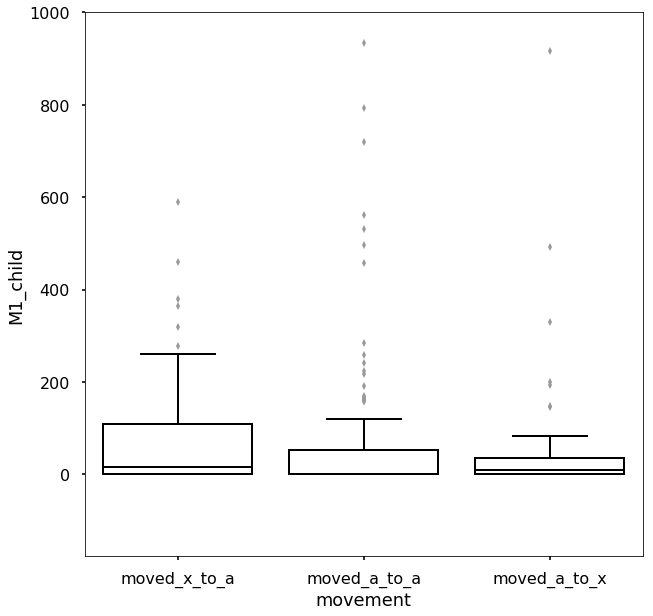

In [329]:
fig = plt.figure(figsize=(10, 10))
ax = sns.boxplot('movement', 'M1_child', data=maria, color='w')
plt.setp(ax.artists, edgecolor='k', facecolor='w', lw=2)
plt.setp(ax.lines, color='k', lw=2)
ax.set_ylim(None, 1000);

Text(0.5,1,'NA droped')

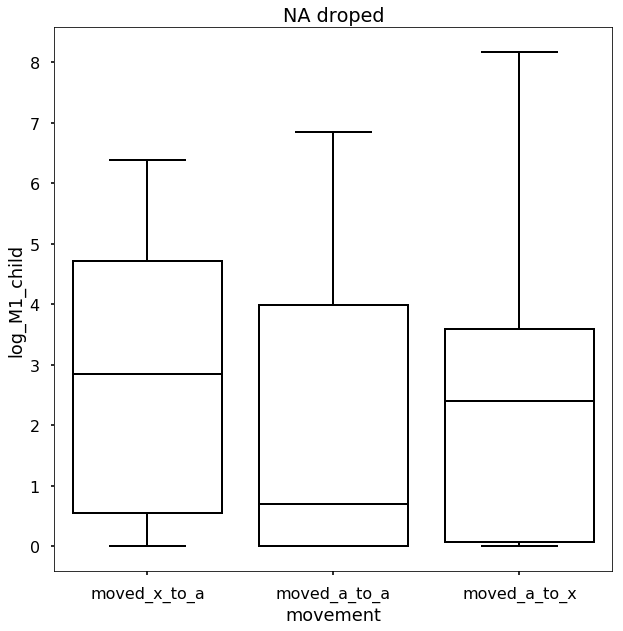

In [330]:
fig = plt.figure(figsize=(10, 10))
ax = sns.boxplot('movement', 'log_M1_child', data=maria, color='w')
plt.setp(ax.artists, edgecolor='k', facecolor='w', lw=2)
plt.setp(ax.lines, color='k', lw=2)
#ax.set_ylim(None, 1000);
ax.set_title('NA droped')

In [331]:
mannwhitneyu(maria.query('movement == "moved_x_to_a"').M1_child.dropna(), maria.query('movement == "moved_a_to_a"').M1_child.dropna(), alternative="two-sided")

MannwhitneyuResult(statistic=5122.0, pvalue=0.009949343088974882)

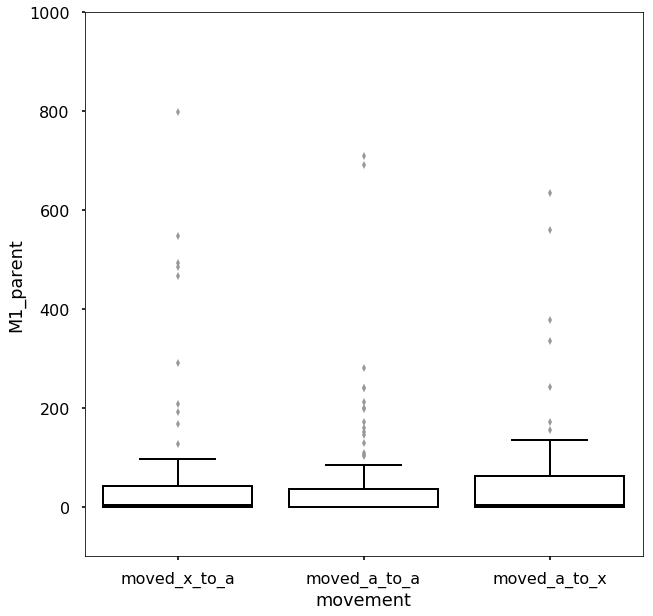

In [332]:
fig = plt.figure(figsize=(10, 10))
ax = sns.boxplot('movement', 'M1_parent', data=maria, color='w')
plt.setp(ax.artists, edgecolor='k', facecolor='w', lw=2)
plt.setp(ax.lines, color='k', lw=2)
ax.set_ylim(None, 1000);

In [333]:
mannwhitneyu(maria.query('movement == "moved_x_to_a"').M1_parent.dropna(), maria.query('movement == "moved_a_to_a"').M1_parent.dropna(), alternative="two-sided")

MannwhitneyuResult(statistic=4937.0, pvalue=0.03878116039755494)

In [334]:
maria.head(20)

,child_chrom,parent_chrom,parent_FBgn,gene_type,moved_x_to_a,moved_a_to_a,moved_a_to_x,biomakrer_cluster,bias_gonia_vs_mid_child,bias_gonia_vs_mid_parent,SP_child,M1_child,SP_parent,M1_parent,movement,log_M1_child
child_FBgn,,,,,,,,,,,,,,,,
FBgn0000246,chr3R,chrX,FBgn0002873,Dl,True,False,False,NaN,None,None,74.507506,40.811514,0.652152,1.751364,moved_x_to_a,3.733172
FBgn0002562,chrX,chr2L,FBgn0002563,D,False,False,True,NaN,None,None,0.023132,0.061855,0.144521,0.137125,moved_a_to_x,0.060017
FBgn0003060,chr3R,chr2L,FBgn0032282,D,False,True,False,NaN,None,None,0.021381,0.000000,0.075548,0.126258,moved_a_to_a,0.000000
FBgn0003086,chrX,chr3L,FBgn0036393,Dl,False,False,True,NaN,None,None,0.000000,0.000000,0.000000,0.057476,moved_a_to_x,0.000000
FBgn0003357,chr3R,chr3L,FBgn0250815,R,False,True,False,NaN,None,None,0.000000,0.000000,0.000000,0.000000,moved_a_to_a,0.000000
FBgn0004414,chr3L,chr2L,FBgn0283658,Rl,False,True,False,NaN,None,None,0.043373,0.695865,4.892144,10.511107,moved_a_to_a,0.528193
FBgn0010549,chr2R,chr3R,FBgn0039645,Dl,False,True,False,NaN,None,None,0.035092,0.223757,0.000000,0.061723,moved_a_to_a,0.201926
FBgn0011559,chr2L,chr3L,FBgn0052133,Dl,False,True,False,NaN,None,None,8.682675,22.154939,6.796721,1.752841,moved_a_to_a,3.142208
FBgn0015008,chr3R,chrX,FBgn0025633,Rl,True,False,False,E1º|L1º|M1º,M1,None,11.194324,212.349137,31.173193,4.033355,moved_x_to_a,5.362930


In [335]:
dat = (maria.groupby('movement').bias_gonia_vs_mid_child.value_counts().div( maria.groupby('movement').size()) * 100).rename('prop').to_frame().reset_index()

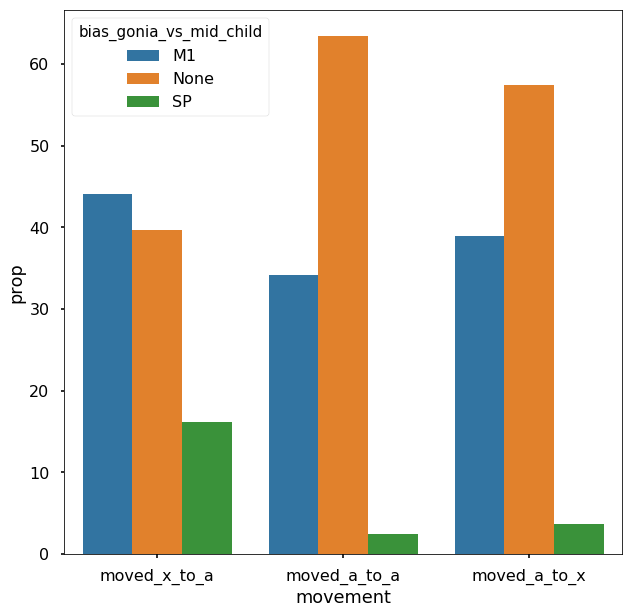

In [336]:
fig = plt.figure(figsize=(10, 10))
sns.barplot('movement', 'prop', hue='bias_gonia_vs_mid_child', data=dat)

In [337]:
fisher_exact(dat.query('movement == ["moved_x_to_a", "moved_a_to_a"] and bias_gonia_vs_mid_child == ["M1", "None"]').set_index(['movement', 'bias_gonia_vs_mid_child']).unstack(), alternative='two-sided')

(2.090497737556561, 0.016590270874298315)

In [338]:
dat.query('movement == ["moved_x_to_a", "moved_a_to_a"] and bias_gonia_vs_mid_child == ["M1", "None"]').set_index(['movement', 'bias_gonia_vs_mid_child']).unstack()

prop           
bias_gonia_vs_mid_child         M1       None
movement                                     
moved_x_to_a             44.117647  39.705882
moved_a_to_a             34.146341  63.414634

In [339]:
movement = (
    pd.read_excel('../data/external/maria/dm6_ver78_genetype.new.xlsx')
    .query('gene_type == ["D", "R", "Dl", "Rl"] and m_type == "M"')
    .assign(child_chrom = lambda df: df.note.str.extract('(chr.*?)-'))
    .assign(parent_chrom = lambda df: df.note.str.extract('-(chr.*?)[:;]'))
    .assign(FBgn = lambda df: df.child_id.map(mapper))
    .set_index("FBgn")
    .drop(['child_id', 'parent_id', 'note', 'm_type'], axis=1)
    .dropna()
) 

movement.loc[(movement.parent_chrom == "chrX") & movement.child_chrom.isin(autosomes), 'movement'] = 'X -> A'
movement.loc[movement.parent_chrom.isin(autosomes) & (movement.child_chrom == "chrX"), 'movement'] = 'A -> X'
movement.loc[movement.parent_chrom.isin(autosomes) & movement.child_chrom.isin(autosomes), 'movement'] = 'A -> A'
movement.movement = pd.Categorical(movement.movement, ordered=True, categories=['X -> A', 'A -> X', 'A -> A'])

In [340]:
m1_tpm = (
    pd.read_parquet('../output/scrnaseq-wf/tpm.parquet')
    .assign(cluster=lambda df: df.cluster.map(config['short_cluster_annot']))
    .query('cluster == "M1º"')
)

(-176.24350757437605, 1010)

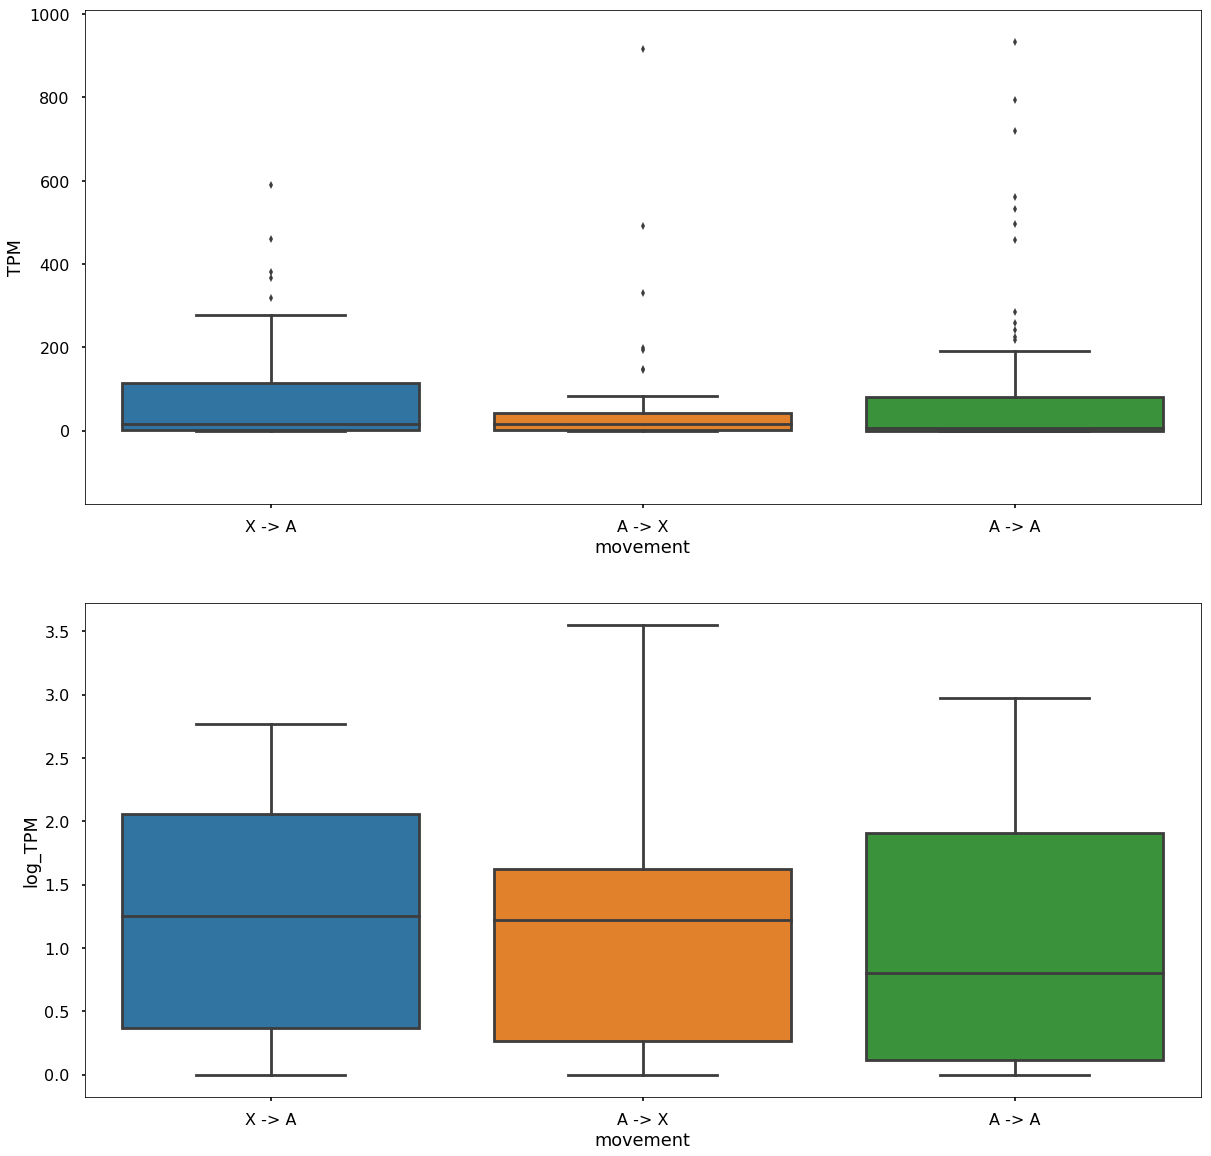

In [341]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
dat = movement.join(m1_tpm).assign(log_TPM=lambda df: np.log10(df.TPM + 1))
sns.boxplot('movement', 'TPM', data=dat, ax=ax1, showfliers=True)
sns.boxplot('movement', 'log_TPM', data=dat, ax=ax2, showfliers=False)
ax1.set_ylim(None, 1010)

In [342]:
dat.groupby('movement').TPM.median()

movement
X -> A    16.802894
A -> X    15.676948
A -> A     5.311457
Name: TPM, dtype: float64

In [343]:
dat.groupby('movement').TPM.size()

movement
X -> A     68
A -> X     54
A -> A    123
Name: TPM, dtype: int64

In [344]:
dat.query('TPM > 0').groupby('movement').TPM.size()

movement
X -> A    59
A -> X    46
A -> A    95
Name: TPM, dtype: int64

In [345]:
from scipy.stats import mannwhitneyu

In [346]:
mannwhitneyu(dat.query('movement == "X -> A"').TPM, dat.query('movement == "A -> A"').TPM)

MannwhitneyuResult(statistic=4004.0, pvalue=0.3137467546698276)

In [347]:
movement = (
    pd.read_excel('../data/external/maria/dm6_ver78_genetype.new.xlsx')
    .query('gene_type == ["D", "R", "Dl", "Rl"] and m_type == "M"')
    .assign(child_chrom = lambda df: df.note.str.extract('(chr.*?)-'))
    .assign(parent_chrom = lambda df: df.note.str.extract('-(chr.*?)[:;]'))
    .assign(FBgn = lambda df: df.child_id.map(mapper))
    .set_index("FBgn")
    .drop(['child_id', 'parent_id', 'note', 'm_type'], axis=1)
    .dropna()
) 

movement.loc[(movement.parent_chrom == "chrX") & movement.child_chrom.isin(autosomes), 'movement'] = 'X -> A'
movement.loc[movement.parent_chrom.isin(autosomes) & (movement.child_chrom == "chrX"), 'movement'] = 'A -> X'
movement.loc[movement.parent_chrom.isin(autosomes) & movement.child_chrom.isin(autosomes), 'movement'] = 'A -> A'
movement.movement = pd.Categorical(movement.movement, ordered=True, categories=['X -> A', 'A -> X', 'A -> A'])

In [348]:
movement.head()

,gene_type,child_chrom,parent_chrom,movement
FBgn,,,,
FBgn0000246,Dl,chr3R,chrX,X -> A
FBgn0002562,D,chrX,chr2L,A -> X
FBgn0003060,D,chr3R,chr2L,A -> A
FBgn0003086,Dl,chrX,chr3L,A -> X
FBgn0003357,R,chr3R,chr3L,A -> A


In [349]:
norm = (
    pd.read_csv('../output/scrnaseq-wf/scrnaseq_combine_force/normalized_read_counts.tsv', sep='\t', index_col=0)
    .rename_axis('FBgn')
    .join(movement, how='inner')
    .reset_index()
    .drop(['parent_chrom', 'child_chrom'], axis=1)
    .melt(id_vars=['FBgn', 'movement', 'gene_type'], var_name='cell_id', value_name='norm')
    .set_index('FBgn')
    .assign(rep=lambda df: df.cell_id.str.extract('(rep\d)', expand=False))
    .join(clusters, on='cell_id')
)

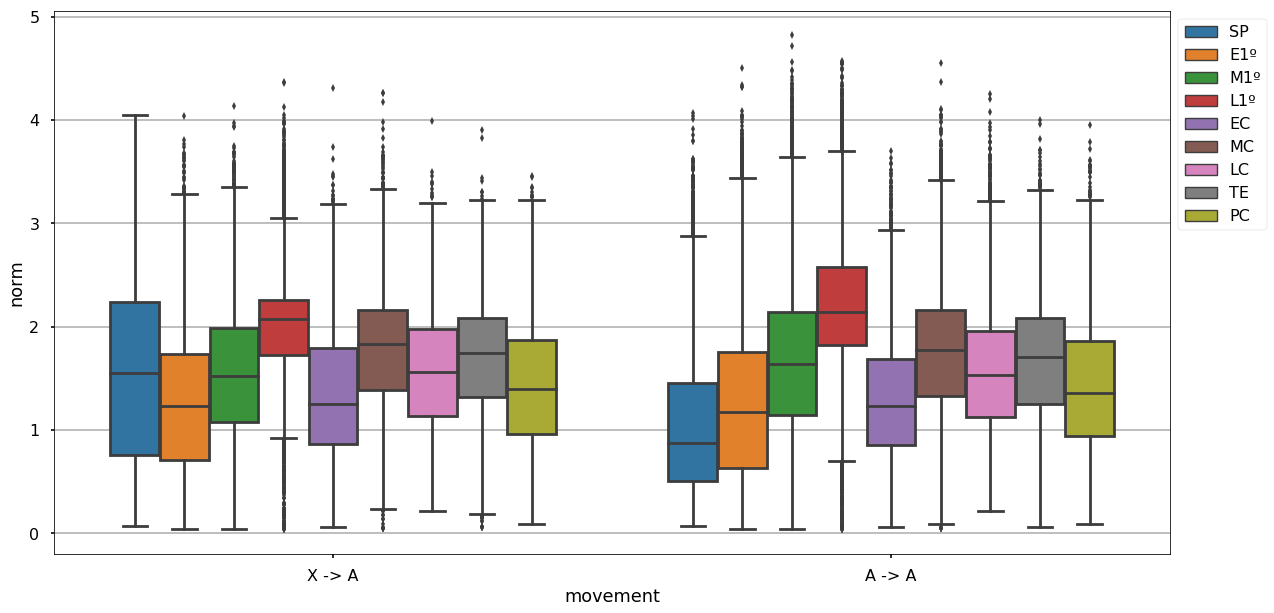

In [350]:
fig = plt.figure(figsize=(20, 10))
ax = sns.boxplot('movement', 'norm', hue='cluster', data=norm.query('norm > 0'), order=['X -> A', 'A -> A'])
plt.legend(loc='upper left', bbox_to_anchor=[1, 1])
ax.set_axisbelow(True)
ax.grid(axis='y')